## Gene Response prediction to Erlotinib 

### A tree based approach

#### Imports 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import shap

from src.data_loader import load_base_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from src.plots import plot_shap_summary, plot_shap_decision

In [3]:
x_train, y_train, x_test = load_base_data()

In [4]:
x_test = x_test.loc[ : , x_train.columns]

In [5]:
x_train.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
CL1,1.672481,45.412546,9.377504,0.860362,0.156075,0.358733,0.013006,90.484463,119.760414,0.000000,...,38.069286,118.897181,201.401740,2.789229,13.546617,40.176298,0.832672,54.266923,27.312810,74.123751
CL2,0.545643,15.886006,0.126553,0.731387,0.000000,3.006263,0.015819,43.455131,37.971081,0.015819,...,40.892433,72.780020,95.990439,4.139704,23.717772,40.655146,0.547275,45.944219,59.511226,66.289158
CL3,1.652956,0.464895,0.353668,0.196430,0.000000,11.393572,0.408079,86.349518,35.893872,0.040808,...,14.024315,33.830939,59.865191,15.289432,18.649139,20.009474,1.570321,23.104745,124.843779,61.950056
CL4,0.795200,0.182806,0.534622,0.239157,0.027417,20.203002,0.342707,74.806003,56.297983,0.027417,...,18.122326,56.826586,120.221485,16.671474,19.477221,25.798955,4.028667,22.369665,138.546988,69.946391
CL5,9.983922,0.222700,0.451019,0.152793,0.233698,1.174855,0.068735,53.228255,36.978543,0.068735,...,47.234577,63.179324,89.121585,1.397236,4.197779,16.001469,0.097534,32.175188,176.770218,62.978656


In [6]:
x_train.shape

(742, 19920)

In [7]:
y_train.head(5)

sample
CL1    0.050705
CL2    0.163113
CL3    0.236655
CL4    0.270218
CL5    0.071619
Name: AAC, dtype: float64

### Scaling, Splitting Feature Selection and training

In [8]:
# standardizing gene expression data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

In [9]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    x_train_scaled, y_train, test_size=0.1, random_state=42
)

In [10]:
# Feature selection
k_best = 500  # Select top 500 features
selector = SelectKBest(mutual_info_regression, k=k_best)
X_train = selector.fit_transform(X_train, y_train)
X_val = selector.transform(X_val)

In [11]:
n = 1200
lr = 1e-3
max_depth = 8
rs = 42

# model Definition
model = XGBRegressor(
    n_estimators = n,       # num trees
    learning_rate = lr,      
    max_depth= max_depth,    # max tree depth
    random_state=rs,         # for reproducibility
    reg_alpha=0.6,       # L1 reg. Default is 0
    reg_lambda=0.1,         # L2 reg. Default is 1
    objective="reg:squarederror",
    eval_metric="rmse",
    device='cpu'
)

# Training with Early Stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

[0]	validation_0-rmse:0.08321
[50]	validation_0-rmse:0.08198
[100]	validation_0-rmse:0.08032
[150]	validation_0-rmse:0.07892
[200]	validation_0-rmse:0.07786
[250]	validation_0-rmse:0.07690
[300]	validation_0-rmse:0.07600
[350]	validation_0-rmse:0.07525
[400]	validation_0-rmse:0.07463
[450]	validation_0-rmse:0.07398
[500]	validation_0-rmse:0.07337
[550]	validation_0-rmse:0.07281
[600]	validation_0-rmse:0.07228
[650]	validation_0-rmse:0.07173
[700]	validation_0-rmse:0.07136
[750]	validation_0-rmse:0.07102
[800]	validation_0-rmse:0.07067
[850]	validation_0-rmse:0.07031
[900]	validation_0-rmse:0.07002
[950]	validation_0-rmse:0.06974
[1000]	validation_0-rmse:0.06948
[1050]	validation_0-rmse:0.06914
[1100]	validation_0-rmse:0.06888
[1150]	validation_0-rmse:0.06869
[1199]	validation_0-rmse:0.06854


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Save Model in pickle format

In [12]:
import pickle
file_name = f"xgb_model.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

# load
model = pickle.load(open(file_name, "rb"))

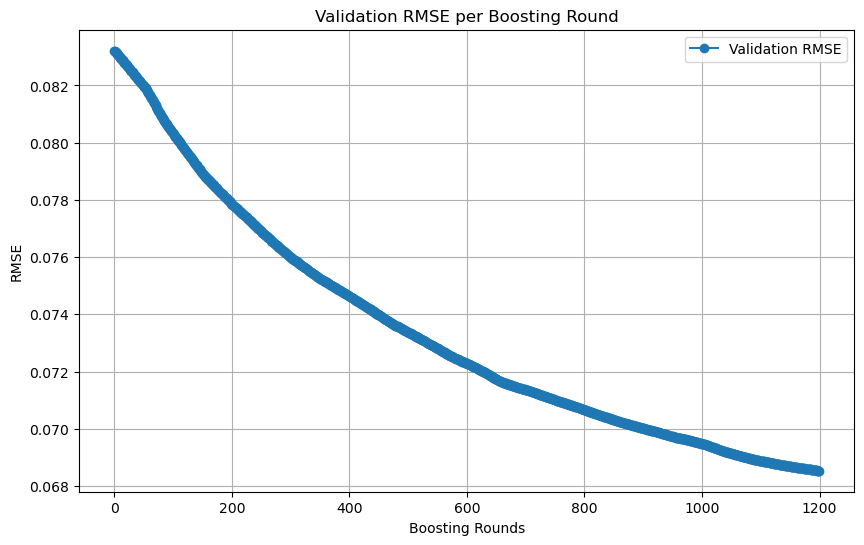

In [13]:
results = model.evals_result()
plt.figure(figsize=(10, 6))
plt.plot(results["validation_0"]["rmse"], label="Validation RMSE", marker="o")
plt.title("Validation RMSE per Boosting Round")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


We could've let it train a little longer since loss hadn't flattened out yet

Spearman Correlation: 0.4666889522803124
RMSE: 0.06853708887662063
R-squared: 0.2613118129249118
x_test shape: (75, 500)


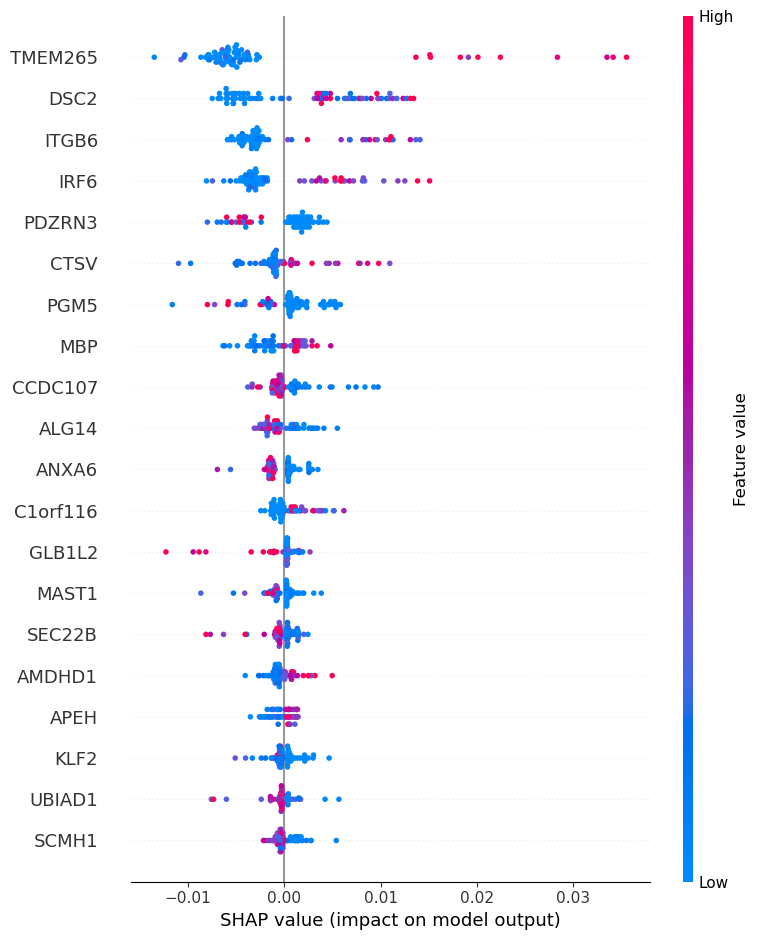

In [16]:
# preds
y_pred = model.predict(X_val)

# eval
spearman_corr, _ = spearmanr(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"Spearman Correlation: {spearman_corr}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

plot_shap_summary(model, X_val, x_train.columns[selector.get_support()])


R² measures the proportion of variance in the target variable that is explained by the model. <br/>
0.234 means ~23.4% of the variance in AAC is explained by the model.

In [17]:
assert len(y_val) == len(y_pred), "Lengths of y_val and y_pred do not match!"

### Saving Predictions for Submission

The problem that is encountered now is that if we put the tissue as training feature, we do not have it for the X_val (normally?) hence won't be able to predict with our model

In [ ]:
from src.submission import generate_submission
generate_submission(model, x_test, scaler, selector, filename_csv="submissions/XGBoost_preds.csv")

2024-12-13 11:42:05,541 - INFO - Generating submission file submissions/XGBoost_augmented.csv
2024-12-13 11:42:05,544 - INFO - Submission file submissions/XGBoost_augmented.csv has been generated successfully
2024-12-13 11:42:05,544 - INFO - Generating pdf file
2024-12-13 11:42:08,701 - INFO - PDF generated: explanations.pdf


### SHAP Explanation Report on test set
Explains the top 5, bottom 5, and median samples, create SHAP explanation plots:

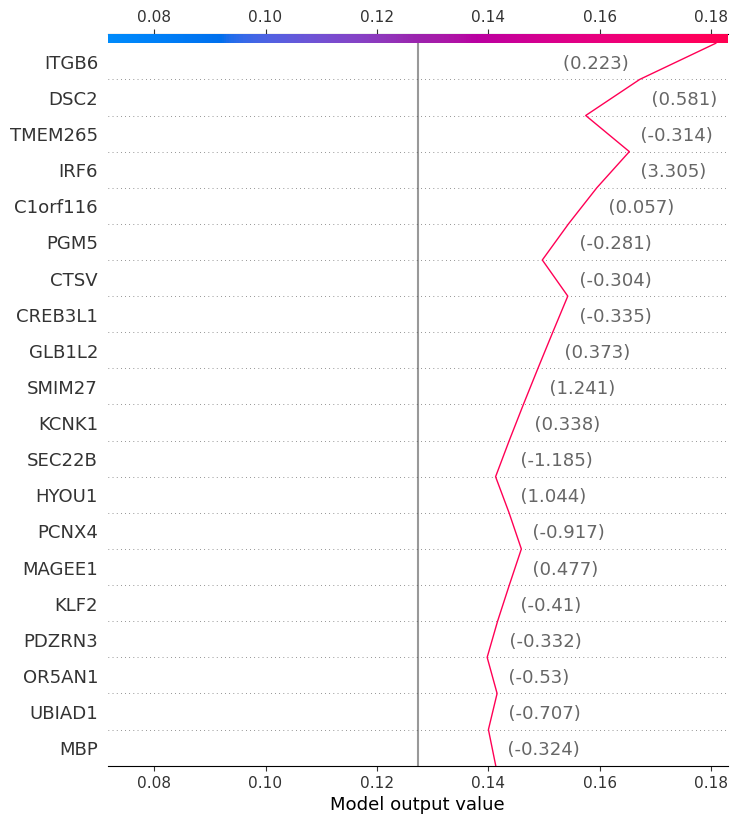

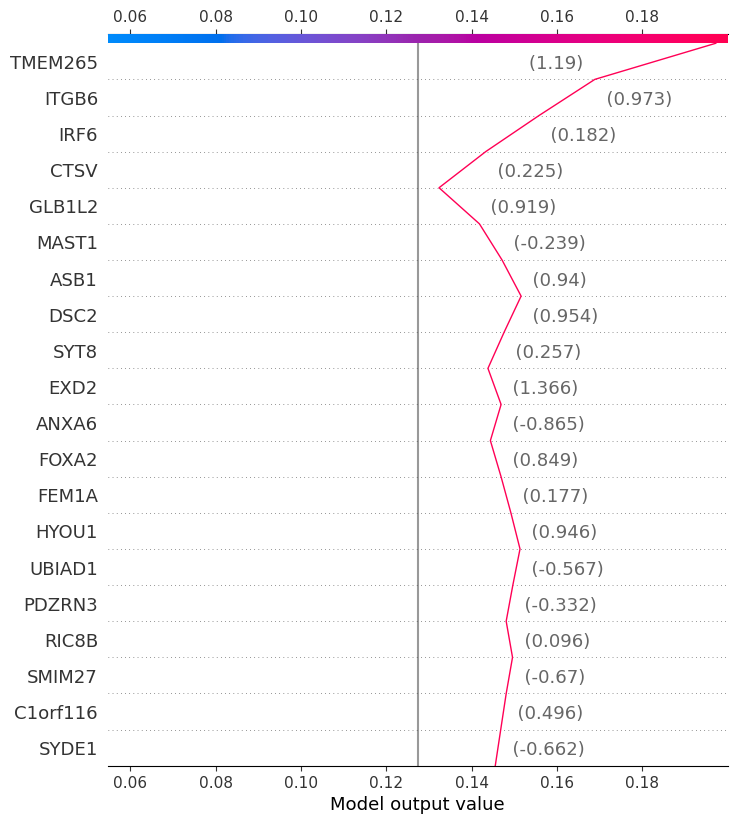

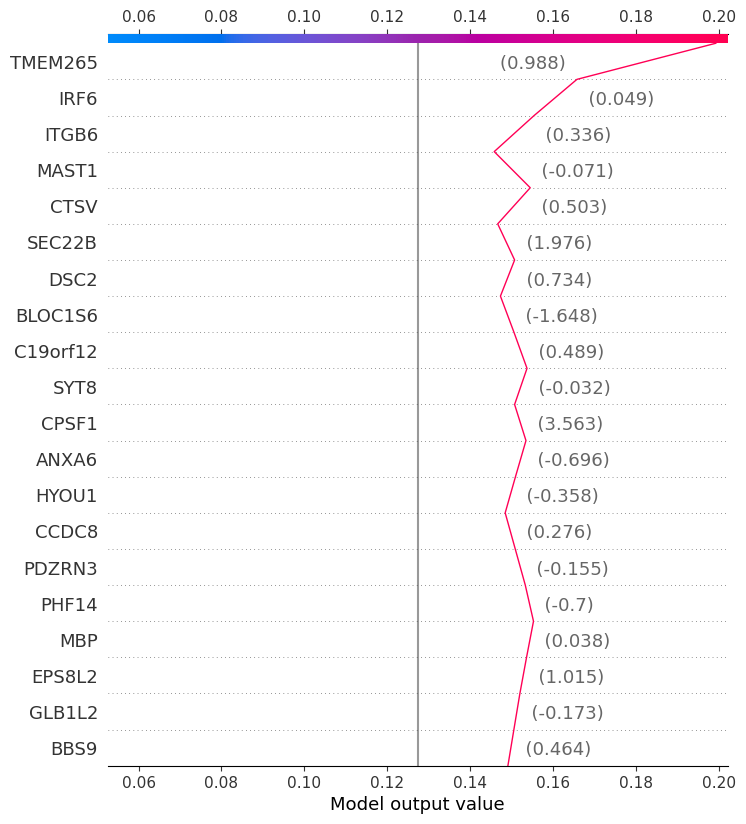

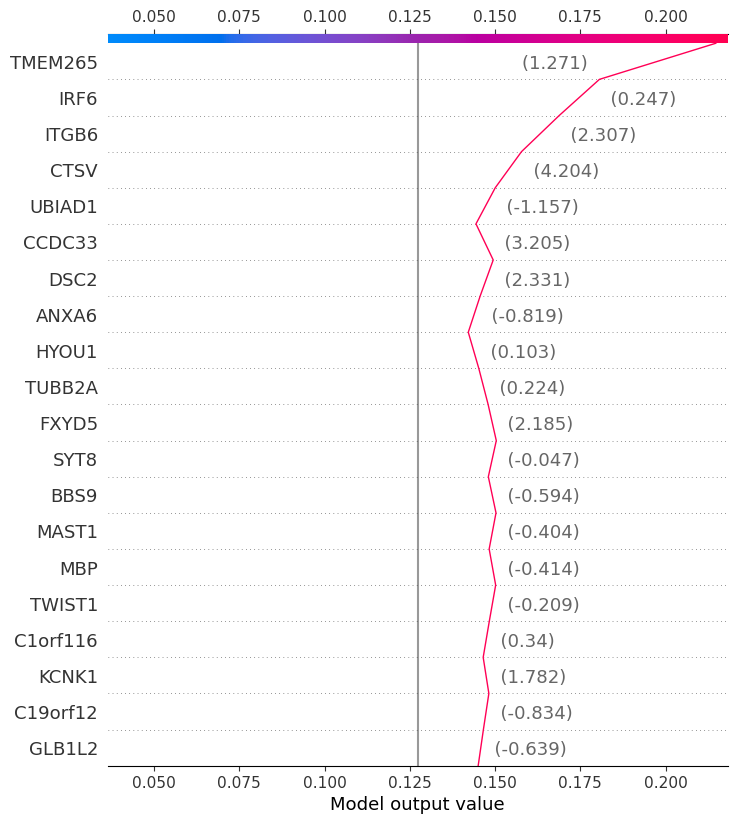

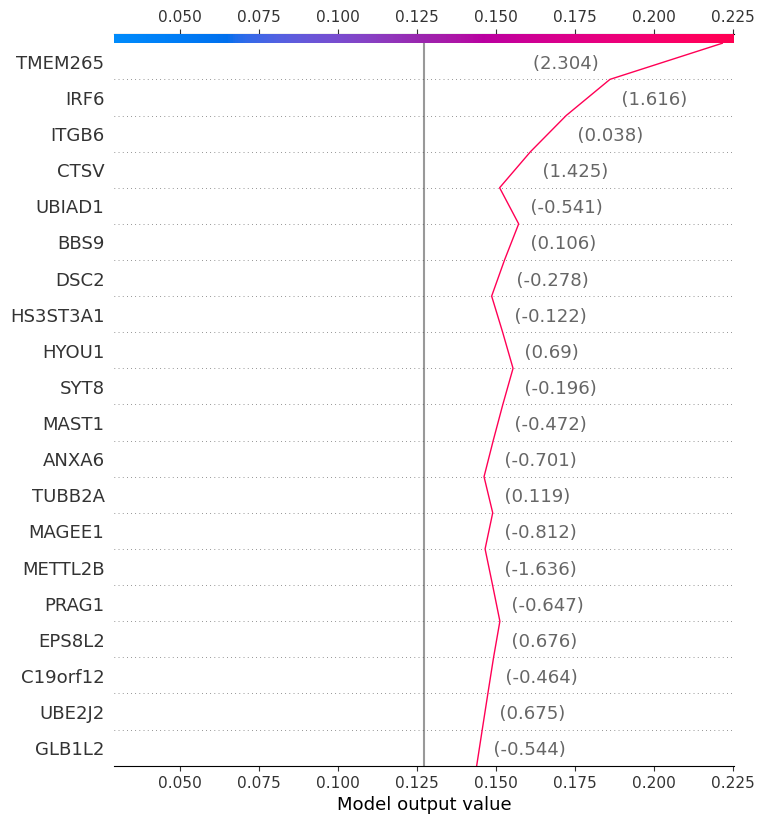

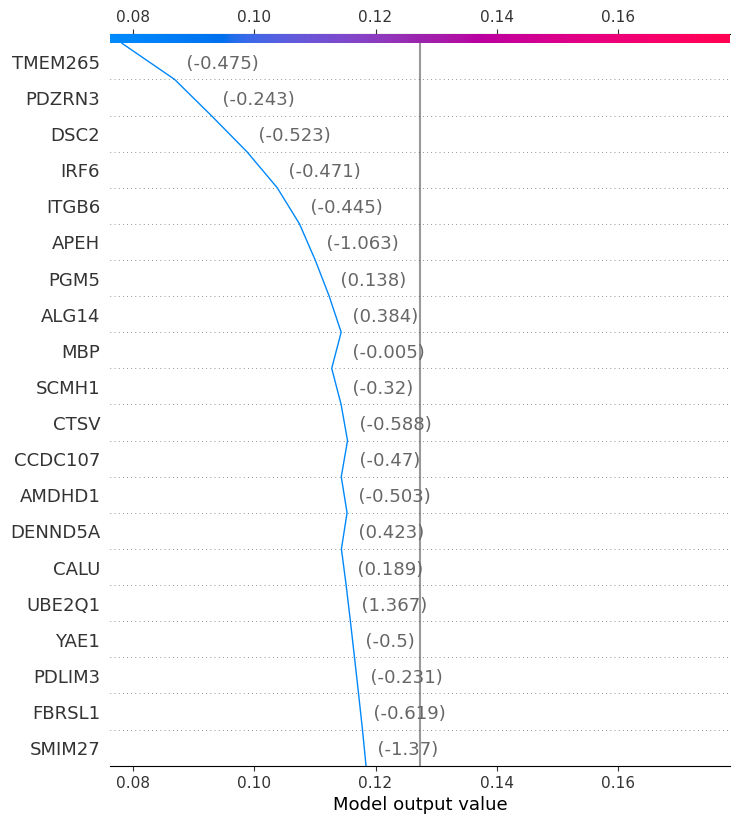

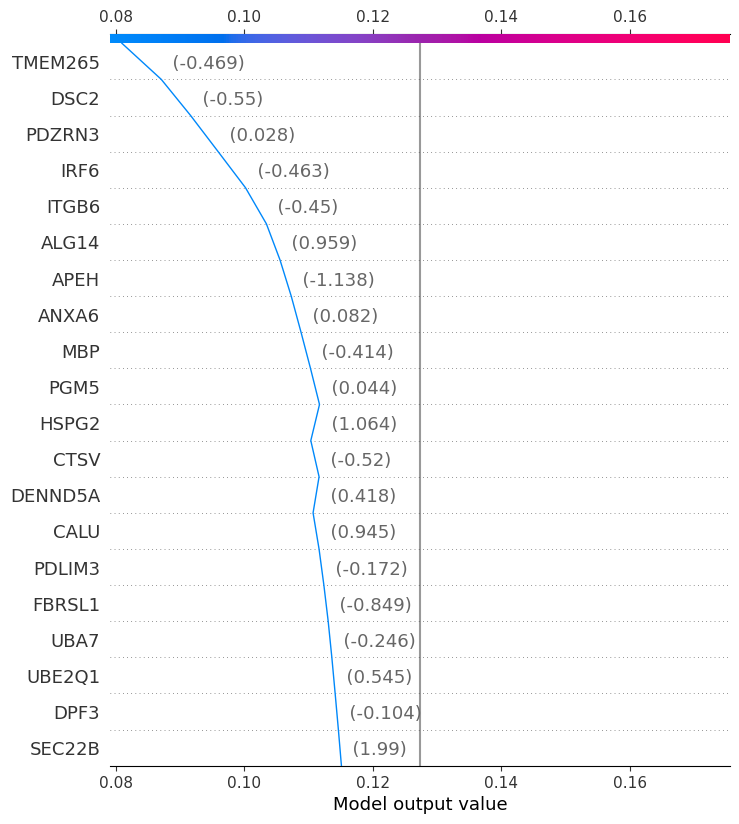

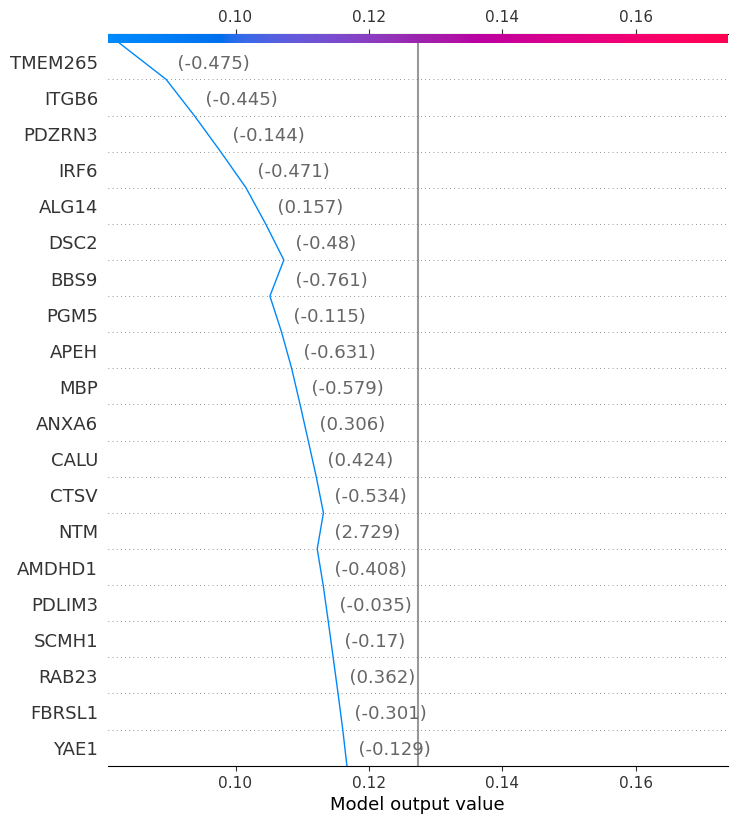

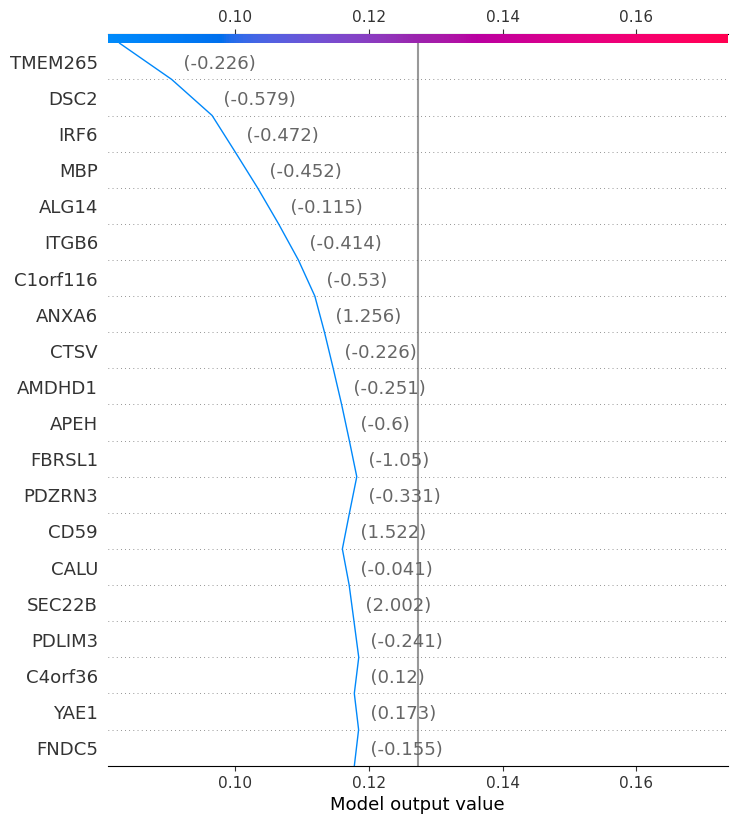

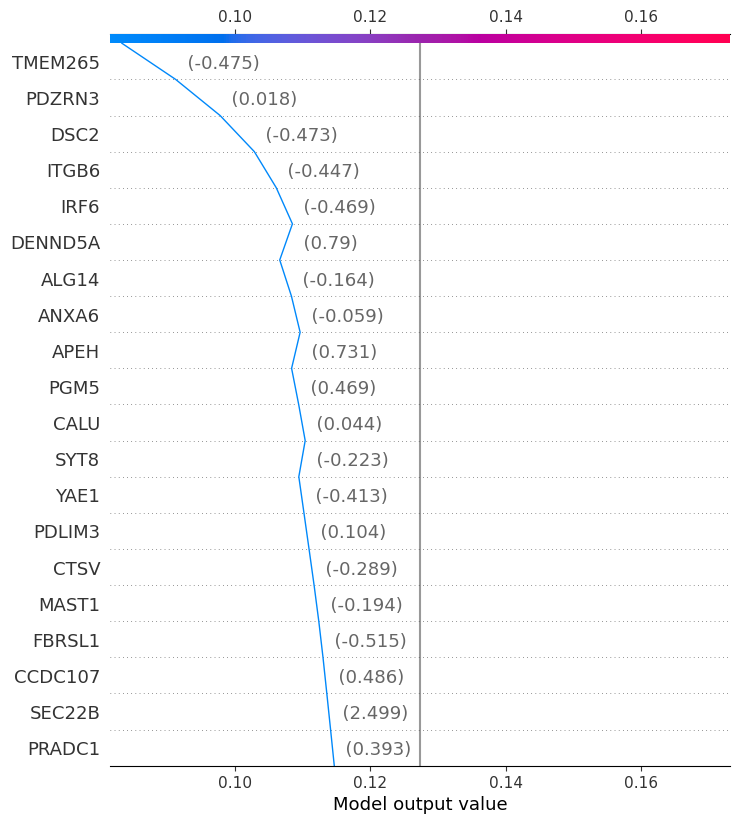

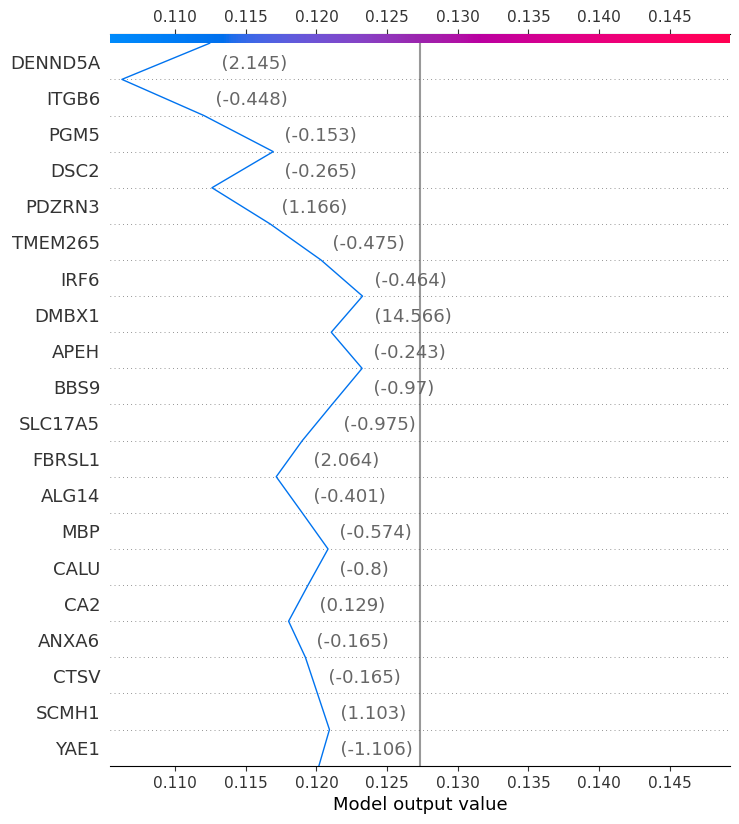

In [27]:
import os 
output_dir = "shap_plots"
y_pred = model.predict(X_val)
plot_shap_decision(model, X_val, y_pred, x_train.columns[selector.get_support()])

## SHAP Summary on test set

x_test shape: (304, 500)


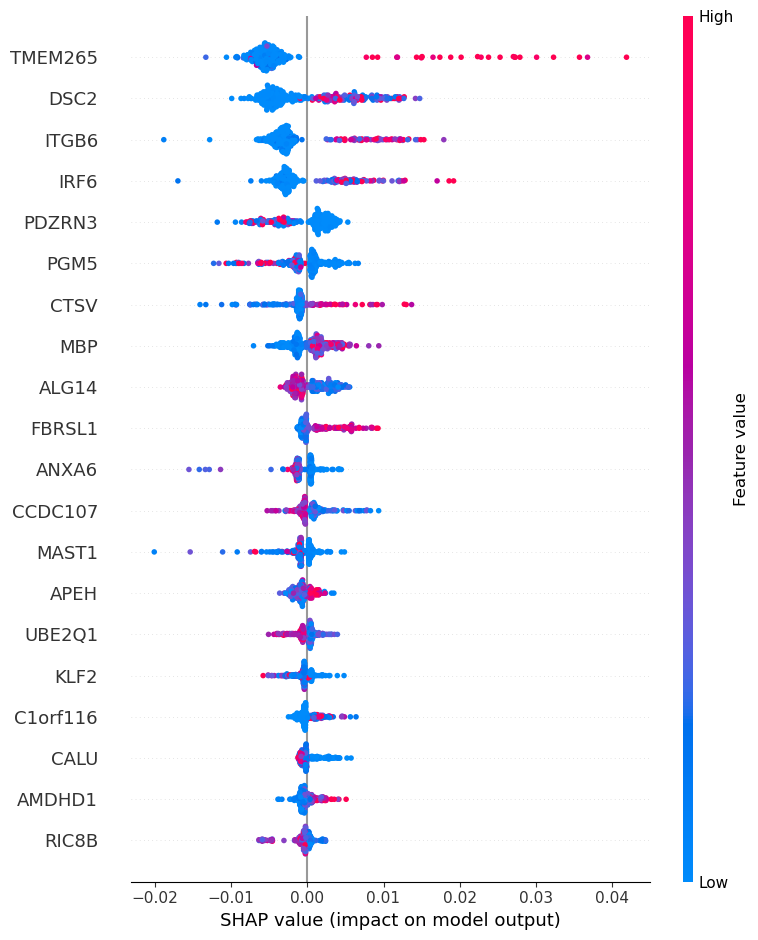

<Figure size 640x480 with 0 Axes>

In [ ]:
output_dir = "shap_plots"
# feature importance
explainer = shap.TreeExplainer(model)

# SHAP summary plot and save
plot_shap_summary(model, x_test, x_train.columns[selector.get_support()])
plt.savefig(os.path.join(output_dir, "shap_summary_plot.png"))

### <b> Prepare and save predictions </b>

In [ ]:
predictions = pd.DataFrame({"sampleId": X_val.index, "AAC": y_pred})
predictions["sampleId"] = predictions["sampleId"].apply(lambda x: x.replace("CL", "TS"))
predictions["sampleId"] = predictions["sampleId"].apply(lambda x: x.replace("CL", "TS"))